In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F4'
VERSION = 'HARDWARE'
SS_VER = 'SS_VER_1_1'

In [2]:
%run "Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [3]:
%%bash -s "$PLATFORM" "$SS_VER"
cd ../hardware/victims/firmware/FrodoKem
make PLATFORM=$1 CRYPTO_TARGET=NONE SS_VER=$2

SS_VER set to SS_VER_1_1
make clean_objs .dep 
make[1]: Entering directory '/home/sou/Documents/FrodoKEMSingleTrace/chipwhisperer/hardware/victims/firmware/FrodoKem'
SS_VER set to SS_VER_1_1
rm -f -- basic-passwdcheck-CW308_STM32F4.hex
rm -f -- basic-passwdcheck-CW308_STM32F4.eep
rm -f -- basic-passwdcheck-CW308_STM32F4.cof
rm -f -- basic-passwdcheck-CW308_STM32F4.elf
rm -f -- basic-passwdcheck-CW308_STM32F4.map
rm -f -- basic-passwdcheck-CW308_STM32F4.sym
rm -f -- basic-passwdcheck-CW308_STM32F4.lss
rm -f -- objdir-CW308_STM32F4/*.o
rm -f -- objdir-CW308_STM32F4/*.lst
rm -f -- basic-passwdcheck.s randombytes.s simpleserial.s stm32f4_hal.s stm32f4_hal_lowlevel.s stm32f4_sysmem.s stm32f4xx_hal_rng.s
rm -f -- basic-passwdcheck.d randombytes.d simpleserial.d stm32f4_hal.d stm32f4_hal_lowlevel.d stm32f4_sysmem.d stm32f4xx_hal_rng.d
rm -f -- basic-passwdcheck.i randombytes.i simpleserial.i stm32f4_hal.i stm32f4_hal_lowlevel.i stm32f4_sysmem.i stm32f4xx_hal_rng.i
make[1]: '.dep' is up to dat

basic-passwdcheck.c: In function 'get_pt':
basic-passwdcheck.c:141:24: warning: passing argument 1 of 'frodo_sample_n' from incompatible pointer type [-Wincompatible-pointer-types]
  141 |         frodo_sample_n(pt,1);
      |                        ^~
      |                        |
      |                        uint8_t * {aka unsigned char *}
basic-passwdcheck.c:59:31: note: expected 'uint16_t *' {aka 'short unsigned int *'} but argument is of type 'uint8_t *' {aka 'unsigned char *'}
   59 | void frodo_sample_n(uint16_t *s, const int n)
      |                     ~~~~~~~~~~^
In file included from .././hal/stm32f4/stm32f4_hal.c:3:
.././hal/stm32f4/stm32f4_hal_lowlevel.h:108: warning: "STM32F415xx" redefined
  108 | #define STM32F415xx
      | 
<command-line>: note: this is the location of the previous definition
In file included from .././hal/stm32f4/stm32f4_hal_lowlevel.c:39:
.././hal/stm32f4/stm32f4_hal_lowlevel.h:108: warning: "STM32F415xx" redefined
  108 | #define STM32F415xx


In [4]:
scope.default_setup()

In [5]:
cw.program_target(scope, cw.programmers.STM32FProgrammer, "../hardware/victims/firmware/FrodoKem/basic-passwdcheck-CW308_STM32F4.hex")


Detected known STMF32: STM32F40xxx/41xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6027 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6027 bytes


In [6]:
#test that the target board is responsive, it should send back a message 'hello'
target.read()

'º\x9b\x11!\x01\x01\x00\x00\x00hello\n'

In [7]:
# Numbre of traces
N = 20000
Ntraining = N- 700
# Numbre of samples per trace
scope.adc.samples = 750

def twos_comp(val, bits):
    """compute the 2's complement of int value val"""
    if (val & (1 << (bits - 1))) != 0: # if sign bit is set e.g., 8bit: 128-255
        val = val - (1 << bits)        # compute negative value
    return val   

In [8]:
import matplotlib.pyplot as plt
import os
import numpy as np 


res_dec = np.zeros(N) 
res_dec_test = np.zeros(N) 
trace1 =np.zeros((N,scope.adc.samples ))
for i in range(N):
    scope.arm()
    option = bytearray([0]*1) # Dummy: enter a random number
    target.simpleserial_write('p', option) 

    res = target.simpleserial_read('r',1, timeout=1000)
    
    
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    trace1[i]= scope.get_last_trace()
    res_dec[i]  = twos_comp(res[0], 8)

 
        

KeyboardInterrupt: 

In [129]:
#This is used to label the data (0.1,2,3,...,-1,-2,..) in two classes 1 and 0 
#for i in range (N):
#    if(abs(res_dec[i]) == 4):
#        res_dec_test[i] = 0
#    else:
#        res_dec_test[i] = 1

In [99]:
#import pickle
#trace_basis =np.zeros((N,scope.adc.samples ))
 
    
#pickle_in = open("trace_basis.pickle","rb") 
#trace_basis = pickle.load(pickle_in)

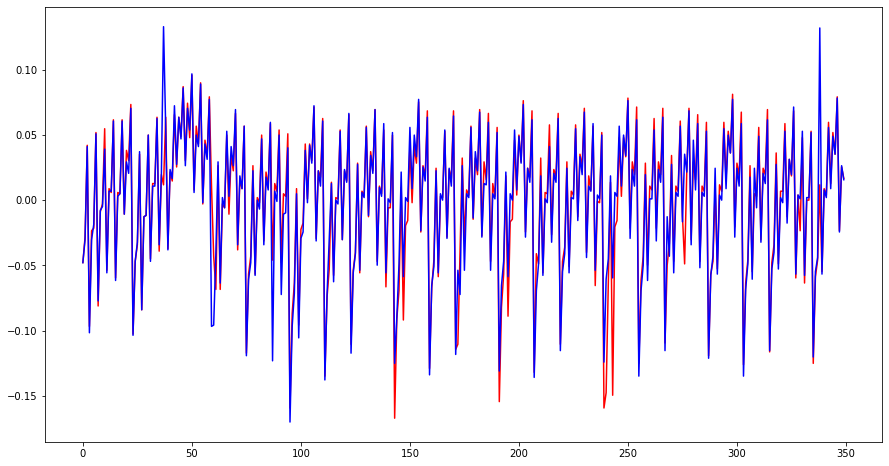

In [100]:
# Visualization
# Try STM32F3 and STMA32F4 and see the differences

%matplotlib inline
import matplotlib.pyplot as plt
plt.figsize=(5,2)
plt.gcf().set_size_inches(15, 8)
plt.plot(trace1[12][50:400], color ='red') 
plt.plot(trace1[2][50:400], color = 'blue') 
#plt.plot(trace1[3][0:700] )
#plt.plot(trace_basis[0][0:500] - trace1[1][0:500])
#plt.plot(trace_basis[0][0:500] - trace1[2][0:500])
#plt.plot(trace_basis[0][0:500] - trace1[3][0:500])
#plt.plot(trace_basis[0][0:500] - trace1[4][0:500])


#plt.plot(trace_basis[1][0:700]) # Gaussian sampling   output is 0
plt.show()
          

In [150]:
#classifier created
#mind the hyperparameters, they are used randomly
from sklearn.neural_network import MLPClassifier 

Dec_clf = MLPClassifier(
    random_state=42,
    solver='adam', 
    learning_rate='adaptive',
    max_iter=2000,
    hidden_layer_sizes=[400],
    batch_size=500,
    early_stopping=True,
    n_iter_no_change=100,
    verbose=False 
)
Dec_clf.fit(trace1[0:9000],  res_dec[0:9000])


MLPClassifier(batch_size=500, early_stopping=True, hidden_layer_sizes=[400],
              learning_rate='adaptive', max_iter=2000, n_iter_no_change=100,
              random_state=42)

In [151]:
predictions = Dec_clf.predict(trace1[9000:10000])

success = 0
for i in range(1000):
    if predictions[i] == res_dec[i+9000]: 
        success = success +1
    else:
        print(predictions[i] , res_dec[i+9000])
print((success /1000)*100)

2.0 3.0
3.0 5.0
2.0 3.0
9.0 10.0
0.0 1.0
2.0 1.0
-2.0 -3.0
3.0 4.0
-7.0 -8.0
1.0 2.0
1.0 2.0
1.0 2.0
98.8


In [152]:
predictions

array([-1., -2., -1.,  4.,  4.,  5.,  6., -4., -2., -1.,  2.,  4., -2.,
        2., -2., -2.,  0.,  0.,  0.,  6., -1., -1.,  2., -6.,  2., -5.,
        3.,  3., -3.,  1., -1.,  5.,  0., -1., -7.,  2.,  6.,  2., -2.,
        2.,  0.,  2.,  1.,  1., -1.,  2.,  6., -1., -2.,  2., -5.,  1.,
        2.,  0.,  0.,  1., -3.,  2.,  7.,  5., -1.,  0.,  0.,  6.,  2.,
        1.,  0.,  0., -3., -1., -6.,  6.,  4.,  0., -1.,  0., -1., -1.,
        1.,  2.,  1.,  4., -1., -4., -7., -7.,  4., -1.,  2.,  1., -2.,
        3.,  1.,  0.,  3., -2., -3., -3.,  2.,  0.,  3., -2., -4., -3.,
        1., -1., -3.,  4., -5.,  0.,  1., -1., -4.,  3., -2., -3., -6.,
       -1.,  0.,  0., -1.,  2.,  4.,  7., -3., -3.,  1.,  0., -1.,  2.,
       -1.,  0.,  0., -3., -1., -1.,  0., -2.,  3., -1.,  2.,  3., -3.,
       -1., -4., -2., -1., -2.,  0.,  0.,  4., -2.,  1.,  1.,  4.,  4.,
       -4.,  0., -2.,  1., -1., -2., -1., -1.,  0.,  1., -5.,  8.,  3.,
       -1., -1., -2., -2., -2.,  0.,  4.,  1., -5., -2., -1.,  0

In [15]:
def decimalToBinary(n):
    # converting decimal to binary
    # and removing the prefix(0b)
    return bin(n).replace("0b", "")
   
# Driver code
if __name__ == '__main__':
    # calling function
    # with decimal argument
    print(decimalToBinary(90))
    print(decimalToBinary(99))



1011010
1100011
